## Medical Image Segmentation
### Winter in Data Science by Analytics Club, IIT Bombay
#### Topic: Brain Tumor Segmentation from multi-model 3D MRI images using 3D U-Net architecture
#### Author: Shantanu Welling

Importing relevant libraries

In [1]:
import json
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons, fixed
import os
import cv2
import glob
import PIL
import shutil
import seaborn as sns
import util
sns.set_style('darkgrid')
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Activation,
    Conv3D,
    Input,
    Conv3DTranspose,
    MaxPooling3D,
    UpSampling3D,
    Dropout
)
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import concatenate
from tensorflow import one_hot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, Sequence
import nilearn as nl
import nilearn.plotting as nlplt
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
K.set_image_data_format("channels_last")

#### Setting numpy random state

In [2]:
np.random.seed(3)

#### Setting the directory path

In [3]:
dir_path="BraTS2020_TrainingData/BraTS20_Training_"

#### Defining functions to load 3D MRI scans and segment masks along with function to view the 3D image

In [4]:
def getimdata(dirpath,testnum):
    testnum=str(testnum).zfill(3)
    dirpath=dirpath+testnum
    impath=dirpath+"/"+dirpath[-20:]+"_"
    im1=nib.load(impath+"t1.nii")
    im2=nib.load(impath+"t1ce.nii")
    im3=nib.load(impath+"t2.nii")
    im4=nib.load(impath+"flair.nii")
    imdat1=im1.get_fdata()
    imdat2=im2.get_fdata()
    imdat3=im3.get_fdata()
    imdat4=im4.get_fdata()
    res=np.array([imdat4]).reshape((240,240,155,1))
    res=np.append(res, imdat1.reshape((240,240,155,1)), axis=3)
    res=np.append(res, imdat2.reshape((240,240,155,1)), axis=3)
    res=np.append(res, imdat3.reshape((240,240,155,1)), axis=3)
    return res

def explore_3dimage(image_data, channel, layer):
    fig=plt.figure(figsize=(10, 5))
    ax=fig.add_subplot()
    ax.imshow(image_data[:, :, layer, channel], cmap='gray');
    ax.set_title('Explore Layers of Brain MRI', fontsize=20)
    fig.text(.5, .0001,f"Plotting Layer {layer} Channel {channel} of Image",ha="center", fontsize="x-large")
    ax.axis('off')
    return layer

def getmaskdata(dirpath, testnum):
    testnum=str(testnum).zfill(3)
    dirpath=dirpath+testnum
    impath=dirpath+"/"+dirpath[-20:]+"_seg.nii"
    maskobj=nib.load(impath)
    maskimg=maskobj.get_fdata()
    maskimg[maskimg>3]=3
    return maskimg

In [5]:
a1=getimdata(dir_path,1) #Sample image
# Get the image shape and print it out
height, width, depth, channels = a1.shape
print(f"The image object has the following dimensions: height: {height}, width:{width}, depth:{depth}, channels:{channels}")

The image object has the following dimensions: height: 240, width:240, depth:155, channels:4


Visualize the data using interactive exploration widgets

In [6]:
interact(explore_3dimage, image_data=fixed(a1), channel=fixed(3), layer=(0, a1.shape[2] - 1));

interactive(children=(IntSlider(value=77, description='layer', max=154), Output()), _dom_classes=('widget-inte…

78

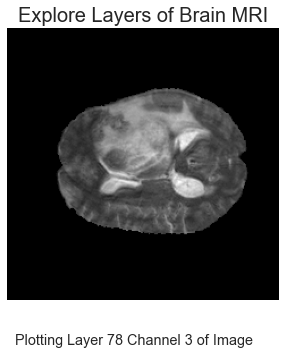

In [7]:
explore_3dimage(a1,3,78)

#### Explore the segmentation masks

In [8]:
mask_img=getmaskdata(dir_path,1)

In [9]:
height, width, depth = mask_img.shape
print(f"Dimensions of mask image array height: {height}, width: {width}, depth: {depth}")
print(f'With the unique values: {np.unique(mask_img)}')
print("""Corresponding to the following label categories: 
0: for normal 
1: for necrotic and non-enhancing tumor 
2: for peritumoral edema 
3: for GD-enhancing tumor""")

Dimensions of mask image array height: 240, width: 240, depth: 155
With the unique values: [0. 1. 2. 3.]
Corresponding to the following label categories: 
0: for normal 
1: for necrotic and non-enhancing tumor 
2: for peritumoral edema 
3: for GD-enhancing tumor


In [10]:
# Define a dictionary of class labels
classes_dict = {
    'Normal': 0.,
    'Non-enhancing tumor': 1.,
    'Edema': 2.,
    'Enhancing tumor': 3. 
}

In [11]:
VOLUME_SLICES = 5
VOLUME_START_AT = 22 # first slice of volume that we will include
IMG_SIZE=128

#### Function to visualize the segmentation masks

In [12]:
def visualize_mask(image, layer):
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(50, 30))
    for i in range(4):
        img_label_str = list(classes_dict.keys())[i]
        img = mask_img[:,:,layer]
        mask = np.where(img == classes_dict[img_label_str], 255, 0)
        ax[i].imshow(mask)
        ax[i].set_title(f"Layer {layer} for {img_label_str}", fontsize=45)
        ax[i].axis('off')
    plt.tight_layout()

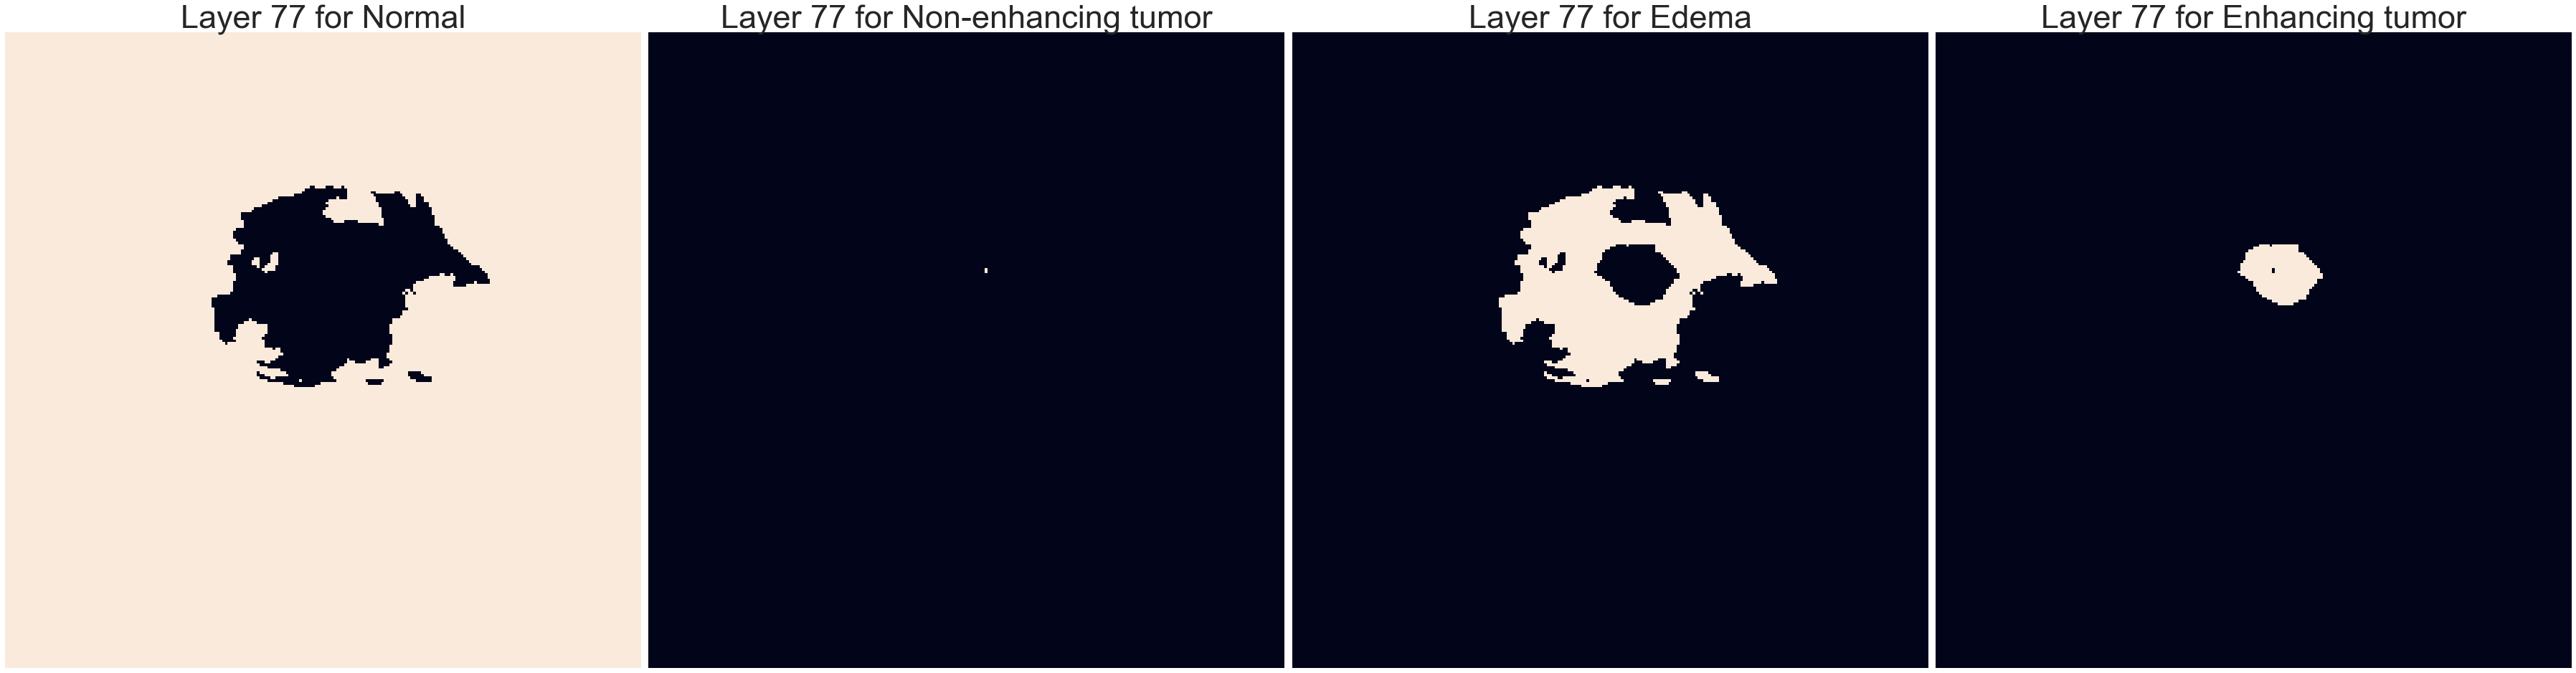

In [13]:
visualize_mask(mask_img,77)

#### Interactive mask visualization

In [14]:
# Create button values
select_class = ToggleButtons(
    options=['Normal','Edema', 'Non-enhancing tumor', 'Enhancing tumor'],
    description='Select Class:',
    disabled=False,
    button_style='info', 
    
)
# Create layer slider
select_layer = IntSlider(min=0, max=154, description='Select Layer', continuous_update=False)

    
# Define a function for plotting images
def plot_image(seg_class, layer):
    print(f"Plotting {layer} Layer Label: {seg_class}")
    img_label = classes_dict[seg_class]
    mask = np.where(mask_img[:,:,layer] == img_label, 255, 0)
    plt.figure(figsize=(10,5))
    plt.imshow(mask, cmap='gray')
    plt.axis('off');

# Use the interactive() tool to create the visualization
interactive(plot_image, seg_class=select_class, layer=select_layer)

interactive(children=(ToggleButtons(button_style='info', description='Select Class:', options=('Normal', 'Edem…

The file util.py has functions to visualize data (taken from AI for Medical Diagnosis course on Coursera)
The colors correspond to each class.
- Red is non enhancing tumor
- Green is a edema
- Blue is an enhancing tumor.


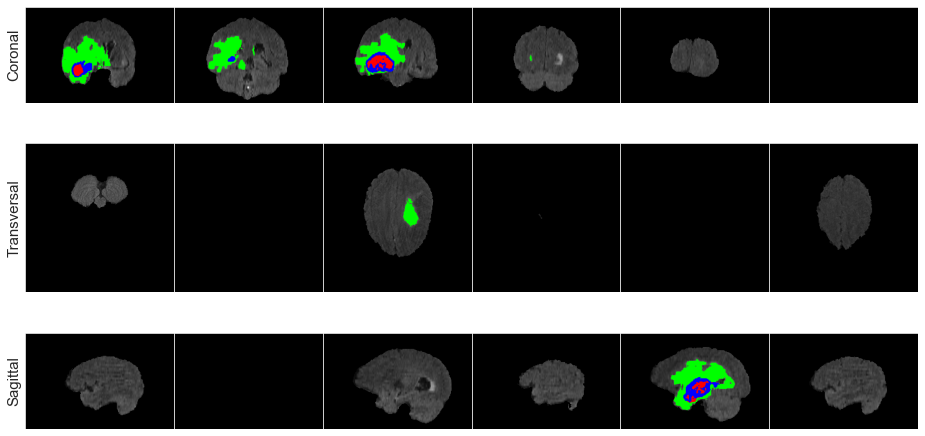

In [15]:
image1=getimdata(dir_path,1)
mask1=getmaskdata(dir_path,1)
im=util.get_labeled_image(image1,mask1)
util.plot_image_grid(im)

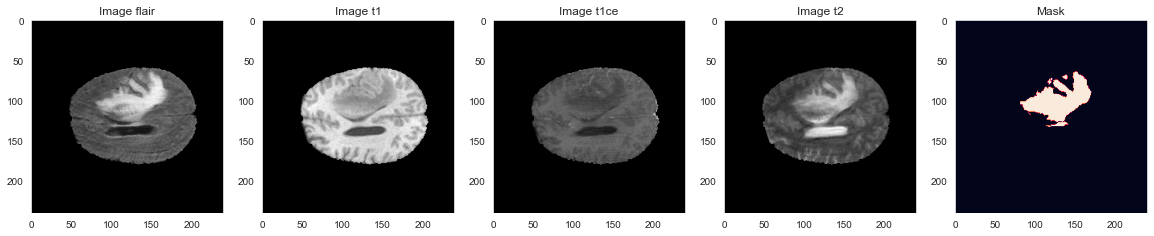

In [16]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(image1[:,:,image1[0].shape[0]//2-slice_w,0], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(image1[:,:,image1[1].shape[0]//2-slice_w,1], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(image1[:,:,image1[2].shape[0]//2-slice_w,2], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(image1[:,:,image1[3].shape[0]//2-slice_w,3], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(mask1[:,:,mask1.shape[0]//2-slice_w])
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)
ax4.grid(False)
ax5.grid(False)
ax5.set_title('Mask');

In [17]:
fig, axes = plt.subplots(nrows=4, figsize=(30, 40))
dpath=dir_path+"001"
niimg=nl.image.load_img(dpath+"/"+dpath[-20:]+"_flair.nii")
nimask=nl.image.load_img(dpath+"/"+dpath[-20:]+"_seg.nii")
nlplt.plot_anat(niimg, title='BraTS20_Training_001_flair.nii plot_anat',axes=axes[0])
nlplt.plot_epi(niimg,title='BraTS20_Training_001_flair.nii plot_epi',axes=axes[1])
nlplt.plot_img(niimg, title='BraTS20_Training_001_flair.nii plot_img', axes=axes[2])
nlplt.plot_roi(nimask, title='BraTS20_Training_001_flair.nii with mask plot_roi', bg_img=niimg, axes=axes[3], cmap='Paired')
plt.show()

#### Standardization, feature scaling and sub-section extraction
Define a function to standard values across each channel and each Z plane to have 0 mean and unit standard deviation.
Sub-section sampling is done because training on a full MRI scan would be too memory intensive to be practical. To extract a sub-section, defined a function to isolate a small "cube" of the data for training.

The function input is:
- a 4D image (shape: \[240, 240, 155, 4\])
- its 3D segmentation mask (shape: \[240, 240, 155\]) arrays, 

The function returns:
 - A randomly generated sub-section of size \[160, 160, 16\]
 - Its corresponding mask which has the shape \[3, 160, 160, 16\]

Additionally: 
1. It makes sure that at most 95% of the returned patch is non-tumor regions. 
2. Given that our network expects the channels for our images to appear as the first dimension (instead of the last one in our current setting) reorder the dimensions of the image to have the channels appear as the first dimension.
3. Reorder the dimensions of the label array to have the first dimension as the classes (instead of the last one in our current setting)
4. Reduce the labels array dimension to only include the non-background classes (total of 3 instead of 4)

#### Performance Metrics

In [18]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
   #     K.print_tensor(loss, message='loss value for class {} : '.format(SEGMENT_CLASSES[i]))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
            
    total_loss = total_loss / class_num
#    K.print_tensor(total_loss, message=' total dice coef: ')
    return total_loss

# define per class evaluation of dice coef
# inspired by https://github.com/keras-team/keras/issues/9395
def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,:,1] * y_pred[:,:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,:,2] * y_pred[:,:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,:,3] * y_pred[:,:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)


# Computing Precision 
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    
# Computing Sensitivity      
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


# Computing Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [19]:
def soft_dice_loss(y_true, y_pred, axis=(1, 2, 3), 
                   epsilon=0.00001):
    """
    Compute mean soft dice loss over all abnormality classes.

    Args:
        y_true (Tensorflow tensor): tensor of ground truth values for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        y_pred (Tensorflow tensor): tensor of soft predictions for all classes.
                                    shape: (num_classes, x_dim, y_dim, z_dim)
        axis (tuple): spatial axes to sum over when computing numerator and
                      denominator in formula for dice loss.
                      Hint: pass this as the 'axis' argument to the K.sum
                            and K.mean functions.
        epsilon (float): small constant added to numerator and denominator to
                        avoid divide by 0 errors.
    Returns:
        dice_loss (float): computed value of dice loss.     
    """

    dice_numerator = 2 * K.sum(y_true * y_pred , axis= axis) + epsilon
    dice_denominator = K.sum(y_true ** 2, axis= axis) + K.sum(y_pred ** 2 , axis = axis) + epsilon
    dice_loss = 1 - K.mean(dice_numerator / dice_denominator)

    return dice_loss

### Building the 3D U-Net Model

In [21]:
TRAIN_DATASET_PATH = 'BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'BraTS2020_ValidationData/'

In [22]:
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
#train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')
train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 


### Data Generator

In [23]:
training_generator = util.DataGenerator(train_ids)
valid_generator = util.DataGenerator(val_ids)
test_generator = util.DataGenerator(test_ids)

In [24]:
def build_unet(inputs, ker_init):
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2), padding="same")(c1)
    
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2), padding="same")(c2)
     
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2), padding="same")(c3)
     
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2), padding="same")(c4)
     
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c5)
    
    #Expansive path 
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c6)
     
    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c7)
     
    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c8)
     
    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=ker_init, padding='same')(c9)
     
    outputs = Conv3D(4, (1, 1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

input_layer = Input((IMG_SIZE, IMG_SIZE, IMG_SIZE, 3))
model = build_unet(input_layer, 'he_normal')
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema ,dice_coef_enhancing] )

In [25]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
filepath="3D-UNet-2018-weights-improvement-{epoch:02d}-{val_accuracy:.3f}.hdf5" 

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stop = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
csv_logger = CSVLogger('training_2020_3D_UNet.log')


In [26]:
steps_per_epoch = 20
n_epochs=10
validation_steps = 20

In [ ]:
history=model.fit(training_generator,
        steps_per_epoch=steps_per_epoch,
        epochs=n_epochs,
        use_multiprocessing=True,
        validation_data=valid_generator,
        callbacks=[checkpoint, csv_logger, early_stop],)

Epoch 1/10


Exception in thread Thread-15:
Traceback (most recent call last):
  File "C:\Shantanu\Anaconda\lib\threading.py", line 973, in _bootstrap_inner
    self.run()
  File "C:\Shantanu\Anaconda\lib\threading.py", line 910, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Shantanu\Anaconda\lib\multiprocessing\pool.py", line 576, in _handle_results
    task = get()
  File "C:\Shantanu\Anaconda\lib\multiprocessing\connection.py", line 255, in recv
    buf = self._recv_bytes()
  File "C:\Shantanu\Anaconda\lib\multiprocessing\connection.py", line 323, in _recv_bytes
    return self._get_more_data(ov, maxsize)
  File "C:\Shantanu\Anaconda\lib\multiprocessing\connection.py", line 342, in _get_more_data
    assert left > 0
AssertionError


In [ ]:
csv_logger = CSVLogger('./evaluation_2020_3D_UNet.log')
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= [csv_logger])
print("test loss, test acc:", results)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics = ['accuracy',tf.keras.metrics.MeanIoU(num_classes=4), dice_coef, precision, sensitivity, specificity, dice_coef_necrotic, dice_coef_edema, dice_coef_enhancing] )
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=100, callbacks= [checkpoint, csv_logger, early_stop])
print("test loss, test acc:", results)